# `alternate_rates`

Sometimes papers provide new measurements of rates that may be better than the current ReacLib library.  These rates are typically provided 
in one of two forms:

* As a new set of fit parameters in the ReacLib format.  An example of this is the 
  {cite:t}`deboer:2017` ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$ rate.
  This type of rate can be added by subclassing the {py:obj}`ReacLibRate <pynucastro.rates.reaclib_rate.ReacLibRate>` class.

* A tabulation of $N_A \langle \sigma v\rangle$ in terms of temperature.  An example of this is the {cite:t}`iliadis:2022`
  ${}^{16}\mathrm{O}(p, \gamma){}^{17}\mathrm{F}$ rate.  This type of rate can be added by
  subclassing the {py:obj}`TemperatureTabularRate <pynucastro.rates.temperature_tabular_rate.TemperatureTabularRate>` class.

We use the {py:mod}`alternate_rates <pynucastro.rates.alternate_rates>` module to hold these rates.

In [1]:
import pynucastro as pyna

## Comparison of de Boer et al. ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$

Here we compare the ReacLib and deBoer et al. versions of ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$.

First get the ReacLib version

In [2]:
rl = pyna.ReacLibLibrary()
c12_rl = rl.get_rate_by_name("c12(a,g)o16")

We can see the source of this rate

In [3]:
c12_rl.source

{'Label': 'nac2',
 'Author': 'Xu, Y. et al.',
 'Title': 'NACRE2',
 'Publisher': 'Nucl. Phys. A 918, P. 61',
 'Year': '2013',
 'URL': 'https://reaclib.jinaweb.org/labels.php?action=viewLabel&label=nac2'}

This comes from the NACRE II compilation of rates.

Now the DeBoer version.  This is available as {py:obj}`DeBoerC12agO16 <pynucastro.rates.alternate_rates.DeBoerC12agO16>`:

In [4]:
from pynucastro.rates.alternate_rates import DeBoerC12agO16
c12_deboer = DeBoerC12agO16()

Note that since DeBoer et al. 2012 give the new rate as a parameterization in the ReacLib form, this new rate just subclasses
{py:obj}`ReacLibRate <pynucastro.rates.reaclib_rate.ReacLibRate>`

In [5]:
DeBoerC12agO16.__base__

pynucastro.rates.reaclib_rate.ReacLibRate

### Comparison with ReacLib

Let's plot a comparison of the rates

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
Ts = np.logspace(7.5, 9.5, 100)

r_rl = np.array([c12_rl.eval(T) for T in Ts])
r_deboer = np.array([c12_deboer.eval(T) for T in Ts])

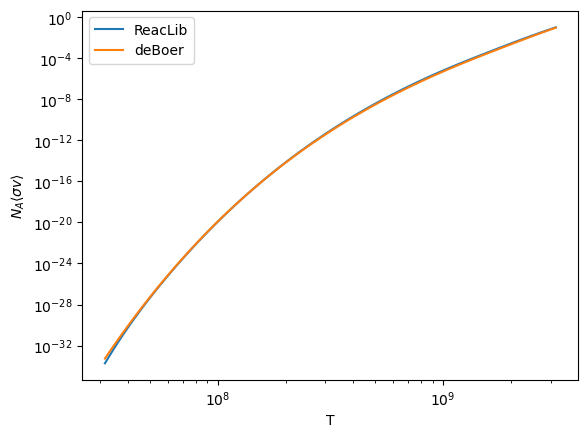

In [8]:
fig, ax = plt.subplots()
ax.loglog(Ts, r_rl, label="ReacLib")
ax.loglog(Ts, r_deboer, label="deBoer")
ax.set_xlabel("T")
ax.set_ylabel(r"$N_A\langle \sigma v\rangle$")
ax.legend()

Here's the relative difference

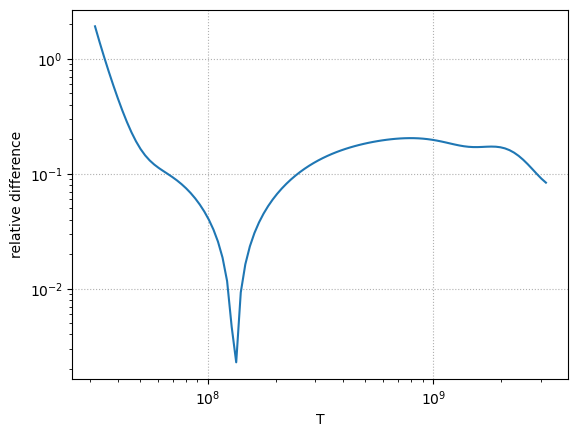

In [9]:
fig, ax = plt.subplots()
ax.loglog(Ts, np.abs((r_rl - r_deboer) / r_rl))
ax.set_xlabel("T")
ax.set_ylabel(r"relative difference")
ax.grid(ls=":")

### Using alternate rates in a network

To create a network with this rate, we can swap it in for the ReacLib version when we create a library.
Here's a simple He-burning network.

In [10]:
nuclei = ["p", "he4", "c12", "o16", "ne20", "na23", "mg24"]

comp = pyna.Composition(nuclei)
comp.set_equal()

In [11]:
rho = 1.e6
T = 1.e9

#### Pure ReacLib

First we'll create a {py:obj}`RateCollection <pynucastro.networks.rate_collection.RateCollection>` with just the ReacLib rates

In [12]:
lib = rl.linking_nuclei(nuclei, with_reverse=False)
rc = pyna.RateCollection(libraries=[lib])
rates = rc.evaluate_rates(rho, T, comp)
for rr, val in rates.items():
    print(f"{str(rr):25} : {val:12.7e}")

C12 + He4 ⟶ O16 + 𝛾       : 2.7441793e-03
O16 + He4 ⟶ Ne20 + 𝛾      : 1.1385847e+00
Ne20 + He4 ⟶ Mg24 + 𝛾     : 4.1265513e-01
Na23 + p ⟶ Mg24 + 𝛾       : 6.9202360e+05
C12 + C12 ⟶ p + Na23      : 1.1970613e-09
C12 + C12 ⟶ He4 + Ne20    : 1.4808559e-09
O16 + C12 ⟶ He4 + Mg24    : 5.5470507e-15
Na23 + p ⟶ He4 + Ne20     : 8.9374939e+06
3 He4 ⟶ C12 + 𝛾           : 2.5845076e-03


#### Swapping in DeBoer rate

Now we'll swap in the deBoer rate, first using {py:func}`remove_rate <pynucastro.rates.library.Library.remove_rate>` to remove the old rate and then using {py:func}`add_rate <pynucastro.rates.library.Library.add_rate>` to add the new rate to the library.

In [13]:
lib.remove_rate(c12_rl)
lib.add_rate(c12_deboer)

and recreate the new `RateCollection`

In [14]:
rc2 = pyna.RateCollection(libraries=[lib])
rates = rc2.evaluate_rates(rho, T, comp)
for rr, val in rates.items():
    print(f"{str(rr):25} : {val:12.7e}")

O16 + He4 ⟶ Ne20 + 𝛾      : 1.1385847e+00
Ne20 + He4 ⟶ Mg24 + 𝛾     : 4.1265513e-01
Na23 + p ⟶ Mg24 + 𝛾       : 6.9202360e+05
C12 + C12 ⟶ p + Na23      : 1.1970613e-09
C12 + C12 ⟶ He4 + Ne20    : 1.4808559e-09
O16 + C12 ⟶ He4 + Mg24    : 5.5470507e-15
Na23 + p ⟶ He4 + Ne20     : 8.9374939e+06
3 He4 ⟶ C12 + 𝛾           : 2.5845076e-03
C12 + He4 ⟶ O16 + 𝛾       : 2.2040004e-03


Comparing to the pure ReacLib version, we see the only difference in the evaluation
of the rates is in ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$

## Comparison of Iliadis et al. 2022 ${}^{16}\mathrm{O}(p,\gamma){}^{17}\mathrm{F}$

The Iliadis et al. 2022 paper provides a tabulation of the ${}^{16}\mathrm{O}(p,\gamma){}^{17}\mathrm{F}$ rate in terms of $T_9$.  We
use the median value of the rate.

First we'll get the ReacLib version

In [15]:
o16_rl = rl.get_rate_by_name("o16(p,g)f17")
o16_rl.source

{'Label': 'ia08',
 'Author': 'Iliadis, C.',
 'Title': 'New reaction rate for 16O( p,&gamma;)17F and its influence on the oxygen isotopic ratios in massive AGB stars',
 'Publisher': 'PRC77, 045802',
 'Year': '2008',
 'URL': 'https://reaclib.jinaweb.org/labels.php?action=viewLabel&label=ia08'}

We see that the ReacLib version of the rate is from an earlier work, Iliadis et al. 2008.

Now we'll get the new version of the rate

In [16]:
from pynucastro.rates.alternate_rates import IliadisO16pgF17
o16_iliadis = IliadisO16pgF17()

and we can see the base now is a temperature tabulation:

In [17]:
IliadisO16pgF17.__base__

pynucastro.rates.temperature_tabular_rate.TemperatureTabularRate

The rate data is stored in the form $(\log_{10}(T_9), \log_{10}(\lambda))$

In [18]:
for lT9, lr in zip(o16_iliadis.log_t9_data, o16_iliadis.log_rate_data):
    print(f"{lT9:11.8f} : {lr:11.8f}")

-5.80914299 : -92.93857540
-5.52146092 : -82.55730565
-5.29831737 : -75.17704808
-5.11599581 : -69.55076155
-4.96184513 : -65.06026927
-4.82831374 : -61.35753485
-4.71053070 : -58.22977031
-4.60517019 : -55.53713719
-4.50986001 : -53.18410182
-4.42284863 : -51.10237820
-4.34280592 : -49.24174730
-4.26869795 : -47.56446689
-4.19970508 : -46.04175153
-4.13516656 : -44.64879623
-4.01738352 : -42.18677046
-3.91202301 : -40.06826948
-3.68887945 : -35.83012428
-3.50655790 : -32.60450514
-3.21887582 : -27.91697136
-2.99573227 : -24.59510705
-2.81341072 : -22.06995494
-2.65926004 : -20.05903267
-2.52572864 : -18.40480739
-2.40794561 : -17.01018169
-2.30258509 : -15.81134652
-2.20727491 : -14.76613397
-2.12026354 : -13.84277899
-2.04022083 : -13.01845391
-1.96611286 : -12.27670973
-1.89711998 : -11.60383534
-1.83258146 : -10.98938107
-1.71479843 : -9.90528917
-1.60943791 : -8.97447805
-1.38629436 : -7.11773584
-1.20397280 : -5.71110925
-1.04982212 : -4.59423025
-0.91629073 : -3.67774171
-0.7985

and we can plot the temperature dependence

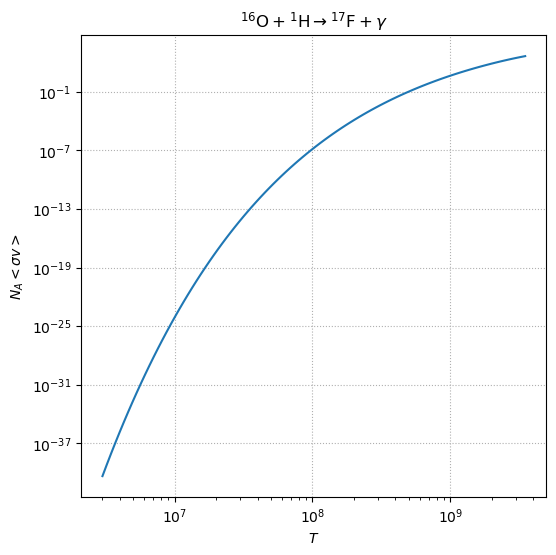

In [19]:
fig = o16_iliadis.plot()

### Comparison with ReacLib

In [20]:
Ts = np.logspace(np.log10(o16_iliadis.table_Tmin), np.log10(o16_iliadis.table_Tmax), 100)
r_rl = np.array([o16_rl.eval(T) for T in Ts])
r_iliadis = np.array([o16_iliadis.eval(T) for T in Ts])

err = np.abs(r_rl - r_iliadis) / r_rl

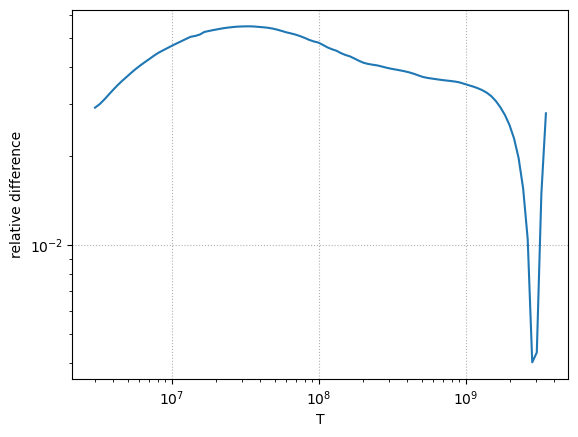

In [21]:
fig, ax = plt.subplots()
ax.loglog(Ts, err)
ax.set_xlabel("T")
ax.set_ylabel(r"relative difference")
ax.grid(ls=":")

We see that the maximum difference is about 5\%